Bài thực hành này chúng ta sẽ thử nhận dạng obj đơn sắc dựa trên mầu sắc của chúng. Dataset chúng ta sử dụng là Digikala (-tên một hệ thống siêu thị lớn ở khu vực châu Á). Dataset gồm các bức ảnh chụp các mặt hàng trên trang web với các mầu sắc khác nhau. Trong bài thực hành này chúng ta sử dụng histogram của kênh mầu H trong HSV để làm vector nhận dạng. Hãy: trích xuất đặc trưng cho tập ảnh => mỗi ảnh = 1 vector histogram(H) và sử dụng nó để nhận dạng Có thể sử dụng KNN hoặc SVM trong sklearn để tính ACC

In [1]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from pathlib import Path
from random import choice

In [2]:
# Đường dẫn gốc
root = 'digikala/train'

# Lấy ảnh ngẫu nhiên trong tập train và gán nhãn
def take_random_img_label():
    paths = list(Path(root).rglob('*.jp*g'))
    path = choice(paths)
    img = cv2.imread(path.as_posix())
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    label = path.parent.stem
    return img, label

#Bo bot vung vien trang xung quanh doi tuong de tang do chinh xac khi nhan dang
def crop_image(img):
    """
    This is a function that crops extra white background
    around product.
    Src:
        https://stackoverflow.com/questions/64046602/how-can-i-crop-an-object-from-surrounding-white-background-in-python-numpy
    """
    mask = img!=255
    mask = mask.any(2)
    mask0,mask1 = mask.any(0),mask.any(1)
    colstart, colend = mask0.argmax(), len(mask0)-mask0[::-1].argmax()+1
    rowstart, rowend = mask1.argmax(), len(mask1)-mask1[::-1].argmax()+1
    return img[rowstart:rowend, colstart:colend]

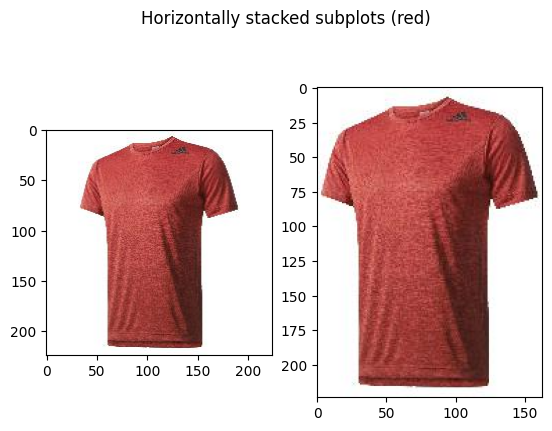

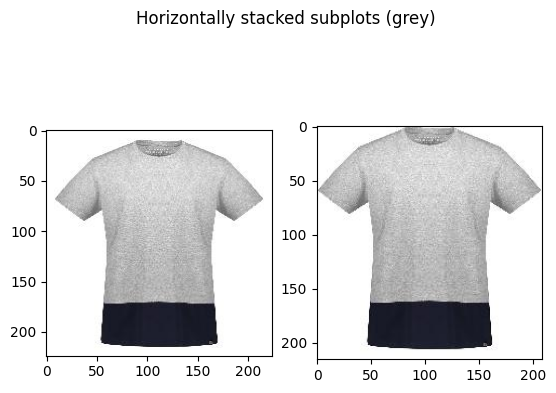

In [3]:
# Lấy tất cả đường dẫn ảnh
images = list(Path(root).rglob('*.jp*g'))

# Lấy n ảnh ngẫu nhiên
n = 2
for i in range(n):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    random_image = choice(images)
    fig.suptitle('Horizontally stacked subplots (' + random_image.parent.stem + ')')
    # Open image and make into Numpy array
    imgBGR = cv2.imread(random_image.as_posix())
    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
    ax1.imshow(imgRGB)
    img = crop_image(imgRGB)
    ax2.imshow(img)
    plt.show()

In [4]:
# tinh histogram cua kenh H tu anh 
def hsv_histogram(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    h = hsv[..., 0]
    return np.bincount(h.ravel(), minlength=256)

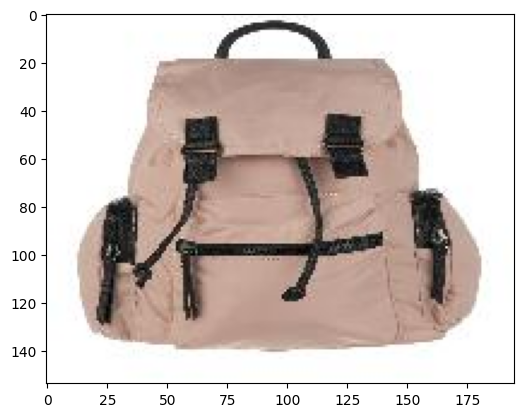

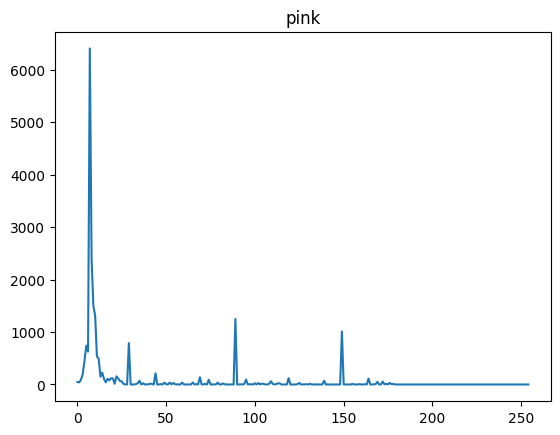

In [6]:
# Vẽ biểu đồ histogram của ảnh ngẫu nhiên
img, label = take_random_img_label()
img = crop_image(img)
plt.imshow(img)
plt.show()

hist = hsv_histogram(img)
plt.plot(hist[1:])
plt.title(label)
plt.show()

In [28]:
# Gán nhãn cho các màu
from os import listdir
from natsort import natsorted

paths = listdir(root)
labels = dict()
for i in range(len(paths)):
    labels.update({paths[i]: i})
# labels = {path: i for i, path in enumerate(natsorted(paths))}
labels

{'black': 0,
 'blue': 1,
 'brown': 2,
 'green': 3,
 'grey': 4,
 'orange': 5,
 'pink': 6,
 'purple': 7,
 'red': 8,
 'silver': 9,
 'white': 10,
 'yellow': 11}

In [29]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler


In [30]:
# Lấy tất cả đường dẫn ảnh
paths = list(Path(root).rglob('*.jp*g'))
# paths = natsorted(list(Path(root).rglob('*.jp*g')), key=lambda x: x.parent.stem)

# mảng lưu trữ features
df = pd.DataFrame(columns=[i for i in range(255)])
col_labels = []

In [31]:
# Tính vector histogram cho tất cả các ảnh
for i, path in enumerate(paths):
    imgBGR = cv2.imread(path.as_posix())
    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
    label = labels[path.parent.stem]
    img = crop_image(imgRGB)
    hist = hsv_histogram(img)
    df = pd.concat([df, pd.DataFrame(hist[1:]).T], ignore_index=True)
    col_labels.append(label) # append labels to insert after the loop

df['labels'] = col_labels # thêm nhãn vào dữ liệu
# path = paths[153]
# imgBGR = cv2.imread(path.as_posix())
# imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
# label = labels[path.parent.stem]
# img = crop_image(imgRGB)
# hist = hsv_histogram(img)
# df = pd.concat([df, pd.DataFrame(hist[1:]).T], ignore_index=True)
# col_labels.append(label) # append labels to insert after the loop

In [32]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,labels
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,36,40,63,50,120,185,40,168,73,76,...,0,0,0,0,0,0,0,0,0,0
4,0,0,41,1,50,3944,0,136,1,14,...,0,0,0,0,0,0,0,0,0,0


In [33]:
df_copy = df.copy()
Y = df_copy.pop('labels')
X = df_copy.copy()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1989)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)

In [34]:
params = {
    SVC.__name__: {},
    KNeighborsClassifier.__name__: dict(metric='manhattan', 
                                        n_neighbors=len(labels))
}

In [35]:
classifier = SVC
Classifier = classifier(**params[classifier.__name__])
Classifier.fit(X_train, y_train)
y_pred = Classifier.predict(X_test)
print(classifier.__name__)
print(accuracy_score(y_test, y_pred))
#print('*' * 20)
#print(classification_report(y_test, y_pred, target_names=list(labels.keys())))

SVC
0.5897435897435898


In [36]:
classifier = KNeighborsClassifier
Classifier = classifier(**params[classifier.__name__])
Classifier.fit(X_train, y_train)
y_pred = Classifier.predict(X_test)
print(classifier.__name__)
print(accuracy_score(y_test, y_pred))
# print('*' * 20)
# print(classification_report(y_test, y_pred, target_names=list(labels.keys())))

KNeighborsClassifier
0.5913461538461539
